In [ ]:
!pip install rfpimp
!pip install eli5
!pip install cxplain
!git clone https://github.com/bondyra/pyBreakDown
%cd ./pyBreakDown
!python3 setup.py install
!pip install shap
!pip install lime

!pip install pdpbox
!pip install --upgrade scikit-learn
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
!pip install numpy --upgrade
!pip install -U tqdm

In [1]:
from sklearn.inspection import plot_partial_dependence, partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, r2_score
from sklearn.neural_network import MLPRegressor
from scipy.special import comb
import scipy as sc
import sklearn as skl
import matplotlib.pyplot as plt
import matplotlib as matplt
import seaborn as sns
import pandas as pd
import numpy as np

import lightgbm as lgbm

from pdpbox import pdp, get_dataset, info_plots
from alepython import ale_plot

import rfpimp as rfpimp
import eli5 as eli5
import cxplain as cxplain
import shap as shap
import lime as lime

from pyBreakDown.explainer import Explainer
from pyBreakDown.explanation import Explanation
from tensorflow.python.keras.losses import categorical_crossentropy, MSE
from cxplain import MLPModelBuilder, ZeroMasking, CXPlain
from tensorflow.python.framework.ops import disable_eager_execution

import numpy as np
from functools import partial
from cxplain.backend.validation import Validation
from cxplain.backend.numpy_math_interface import NumpyInterface
from cxplain.backend.masking.base_masking import BaseMasking
from cxplain.backend.masking.masking_util import MaskingUtil
import itertools
import collections
import numpy as np
from cxplain.backend.validation import Validation
from cxplain.backend.numpy_math_interface import NumpyInterface

import os, sys
import warnings
from contextlib import contextmanager
from tqdm.notebook import tqdm
from timeit import default_timer as timer
from google.colab import drive
from copy import deepcopy
from IPython.utils import io
import pickle

%load_ext autoreload
%autoreload 2
%pylab inline
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
sns.set_palette("tab10")
drive.mount('/content/drive')
disable_eager_execution()
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Mounted at /content/drive
Found GPU at: 


In [2]:
path_to_datasets = "/content/drive/MyDrive/6_sem/dyakonov/experiments/artificial/"
random_state = 99
np.random.seed(random_state)

# Implementation of functions used further   

In [3]:
# masking for cxplain

class PermutationMasking(BaseMasking):
    def __init__(self):
        super(PermutationMasking, self).__init__()

    def get_predictions_after_masking(self, explained_model, X, y, downsample_factors=(1,), batch_size=64,
                                      flatten=False):
        Validation.check_dataset(X, y)

        num_batches = int(np.ceil(len(X) / float(batch_size)))

        all_outputs = []
        for batch_idx in range(num_batches):
            x = X[batch_idx*batch_size:(batch_idx+1)*batch_size]
            y_pred = MaskingUtil.get_prediction(explained_model, x, flatten=flatten)
            x_imputed = get_x_permuted(x, downsample_factors, math_ops=NumpyInterface)

            all_y_pred_imputed = []
            for x_imputed_curr in x_imputed:
                y_pred_imputed = MaskingUtil.get_prediction(explained_model, x_imputed_curr, flatten=flatten)
                all_y_pred_imputed.append(y_pred_imputed)

            all_y_pred_imputed = np.stack(all_y_pred_imputed).swapaxes(0, 1)

            all_outputs.append((x, y_pred, all_y_pred_imputed))

        all_outputs = [np.concatenate(list(map(partial(lambda x, dim: x[dim], dim=dim), all_outputs)))
                       for dim in range(len(all_outputs[0]))]
        return all_outputs


def get_x_permuted(x, downsample_factors, math_ops):
        input_dim = np.array(x[0]).shape
        num_indices, num_channels, _, downsampling_factor =\
            MaskingUtil.get_input_constants(input_dim, downsample_factors)

        if num_indices is None:
            raise ValueError("Variable length inputs are currently not supported for ZeroMasking.")

        all_x_imputed = []
        for i in range(num_indices):
            def predict_with_i_imputed(x, index):
                x_imputed = math_ops.copy(x)
                original_shape = math_ops.shape(x_imputed)
                target_shape = (original_shape[0], math_ops.as_int(math_ops.prod(original_shape[1:])))

                if downsampling_factor == 1:
                    needs_reshape = len(original_shape) > 2
                    if needs_reshape:
                        x_imputed = math_ops.reshape(x_imputed, target_shape)

                    # print(x_imputed, index)
                    x_imputed = np.array(x_imputed)
                    uni, counts = np.unique(x_imputed[:, index], return_counts=True)
                    x_imputed[:, index] = np.random.choice(uni, size=x_imputed.shape[0], p=counts/counts.sum())
                    
                    if needs_reshape:
                        x_imputed = math_ops.reshape(x_imputed, original_shape)
                else:
                    full_shape = Validation.get_full_input_shape(original_shape[0], input_dim)
                    mask = MaskingUtil.get_ith_mask(index, input_dim, downsample_factors, math_ops=math_ops)
                    x_imputed = math_ops.reshape(x_imputed, full_shape)

                    inverted_mask = (mask - 1.) * -1.
                    x_imputed = math_ops.multiply(x_imputed,
                                                  math_ops.expand_dims(math_ops.cast(inverted_mask, float),
                                                                       axis=-1))

                return x_imputed

            current_x_imputed = predict_with_i_imputed(x, index=i)
            all_x_imputed.append(current_x_imputed)
        return all_x_imputed


def sec_to_date_string(time_last):
    h = time_last // (60 * 60)
    m = (time_last % (60 * 60)) // 60
    s = (time_last % (60 * 60)) % 60
    return '{0}h {1}min {2}sec'.format(h, m, s)


# For filter methods 

def f1_metric(model, X_valid, y_valid, sample_weights=None):
    return f1_score(y_valid, model.predict(X_valid))


def r2_metric(model, X_valid, y_valid, sample_weights=None):
    return r2_score(y_valid, model.predict(X_valid))


def all_feature_interaction(clf, X, n_samples=1000):
    """Finds feature interaction value for each column in X.

    The FI value is the amount of the variance explained by 
    the interaction (difference between observed and no-interaction Partial Dependence)

    Parameters
    ----------
    X : pandas frame
    clf : must have predict and decision function

    Returns
    -------
    H2_all : numpy array
        All feature interaction in the same column order as given in X
    """
    preds = clf.predict(X).reshape(-1, 1)
    pd_one_m = pd_one(clf, X, n_samples)
    pd_all_exc_one_m = pd_all_exc_one(clf, X, n_samples)

    norm_term = np.sum(np.square(preds))

    H2_all = np.sum(np.square(preds - pd_one_m - pd_all_exc_one_m), axis=0) / norm_term

    return H2_all.ravel()


def pd_all_exc_one(clf, X, n_samples=1000):
    """Computes matrix (X.shape[0] x X.shape[1]), where in (i,j) position value 
    is equal to pdp(all_variables_except_j == values in row i)

    Parameters
    ----------
    X : pandas dataframe
    clf : must have predict function
    n_samples : int
        Amount of sampled data to calculate pd

    Returns
    -------
    answer : numpy array of shape (X.shape[0], X.shape[1]) 
    """

    answer = np.empty((X.shape[0], X.shape[1]))
    num_cols = len(X.columns)
    nunique = []
    for col_i in range(num_cols):
        uni = X.iloc[:, col_i].unique()
        if uni.shape[0] > n_samples:
            uni = np.random.choice(uni, n_samples, replace=False)
        nunique.append(uni)

    ind_r = 0
    for row in X.values:
        for i in range(num_cols):
            preds = []
            for uniq in nunique[i]:
                mrow = row
                mrow[i] = uniq
                preds.append(clf.predict(mrow.reshape(1, -1)))
            answer[ind_r, i] = np.array(preds).mean()
        ind_r += 1
    return answer


def pd_one(clf, X, n_samples=1000):
    """Computes matrix (X.shape[0] x X.shape[1]), where in (i,j) position value 
    is equal to pdp(j_variable == value in row i)

    Parameters
    ----------
    X : pandas dataframe
    clf : must have predict function
    n_samples : int
        Amount of sampled data to calculate pd

    Returns
    -------
    answer : numpy array of shape (X.shape[0], X.shape[1]) 
    """
    answer = np.empty((X.shape[0], X.shape[1]))
    num_cols = len(X.columns)
    nunique = []
    for col_i in range(num_cols):
        nunique.append(X.iloc[:, col_i].unique())

    ind_r = 0
    for row in X.values:
        for i in range(num_cols):
            samples_not_i = np.empty((n_samples, num_cols - 1))
            for j in range(num_cols - 1):
                add_ind = 0
                if (j > i):
                    add_ind = 1

                samples_not_i[:, j] = np.random.choice(nunique[j + add_ind], size=n_samples)

            data = np.hstack((samples_not_i[:, :j], np.full((n_samples, 1), row[i]), samples_not_i[:, j:]))
            answer[ind_r, i] = clf.predict(data).mean()
        ind_r += 1
    return answer


# For experiments 

def rfpimp_dt_im(clf, X_valid, y_valid, metric, **kwargs):

    im = rfpimp.importances(clf, X_valid, y_valid, metric=metric)
    for i in range(999):
        im += rfpimp.importances(clf, X_valid, y_valid, metric=metric,)
    im /= 1000
    im.columns = ['rfpimp (permutation)']
    return im.fillna(0)


def eli5_dt_im(clf, X_train, **kwargs):

    p = None
    try:
        p = eli5.explain_weights_lightgbm(clf, importance_type='gain')
        im = p.feature_importances.importances
        fi = pd.DataFrame(index=X_train.columns, columns=['eli5 (gain)'])
        for el in im:
            fi.loc[el.feature] = el.weight
        return fi.fillna(0)
    except:
        pass
    
    try:
        def replace_to_name(x):
            return X_train.columns[int(x[1:])]

        p = eli5.explain_weights_df(clf)
        p = p[p['feature'] != '<BIAS>']
        p['feature'] = p.feature.apply(replace_to_name)
        del p['target']
        p.columns = ['index', 'eli5']
        p.set_index('index', inplace=True)
        return p.fillna(0)
    except:
        pass
    
    if p is None:
        raise ValueError('Wrong type of clf')
    


def pyBreakDown_dt_im(clf, X_train, X_valid, **kwargs):

    exp = Explainer(clf=clf, data=X_train, colnames=X_train.columns)
    fi = pd.DataFrame(index=np.arange(X_valid.shape[0]), columns=X_train.columns)
    for i in range(X_valid.shape[0]):
        explanation = exp.explain(X_valid.values[i, :], direction='up')
        for attr in explanation._attributes:
            fi.iloc[i][attr.name] = attr.contribution
    fi = pd.DataFrame(data=fi.mean(axis=0), columns=['pyBreakDown (up)'])
    return fi.fillna(0)


def shap_dt_im(clf, X_train, X_valid, **kwargs):

    explainer = None
    im = None
    try:
        explainer = shap.explainers.Tree(clf, X_train, random_state=random_state)
        im = np.mean(np.array(explainer.shap_values(X_valid, nsamples=100)), axis=0)
        fi = pd.DataFrame(data=pd.Series(data=im, index=X_train.columns), columns=['shap (Tree)'])
        return fi.fillna(0)
    except:
        pass
    
    try:
        explainer = shap.KernelExplainer(clf.predict_proba, X_train, random_state=random_state)
        im = np.mean(np.array(explainer.shap_values(X_valid, nsamples=100)[0]), axis=0)
        fi = pd.DataFrame(data=pd.Series(data=im, index=X_train.columns), columns=['shap (Kernel)'])
        return fi.fillna(0)
    except:
        pass
    
    if explainer is None:
        raise ValueError('Wrong type of clf')


def lime_dt_im(clf, X_train, X_valid, **kwargs):
    
    if not kwargs['regression']:
        explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, random_state=random_state)
        fi = pd.DataFrame(index=np.arange(X_valid.shape[0]), columns=X_train.columns)
        for i in range(X_valid.shape[0]):
            explanation = explainer.explain_instance(X_valid.values[i, :], clf.predict_proba).as_list()
            ind_c = 0
            for attr in explanation:
                fi.iloc[i][X_valid.columns[ind_c]] = attr[1]
                ind_c += 1
    else:
        explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, random_state=random_state, mode='regression')
        fi = pd.DataFrame(index=np.arange(X_valid.shape[0]), columns=X_train.columns)
        for i in range(X_valid.shape[0]):
            explanation = explainer.explain_instance(X_valid.values[i, :], clf.predict).as_list()
            ind_c = 0
            for attr in explanation:
                fi.iloc[i][X_valid.columns[ind_c]] = attr[1]
                ind_c += 1

    fi = pd.DataFrame(data=fi.mean(axis=0), columns=['lime'])
    return fi.fillna(0)


def cxplain_dt_im(clf, X_train, y_train, X_valid, y_valid, **kwargs):
    if kwargs['regression']:
        loss = MSE
    else:
        loss = categorical_crossentropy

    model_builder = MLPModelBuilder(num_layers=2, num_units=64, batch_size=8, 
                                    num_epochs=100, p_dropout=0.2, early_stopping_patience=15)
    masking_operation = PermutationMasking()

    explainer = CXPlain(clf, model_builder, masking_operation, loss)
    explainer.fit(X_train.values, y_train.values)

    attributions = np.median(explainer.explain(X_valid.values), axis=0)
    fi = pd.DataFrame(data=pd.Series(data=attributions, index=X_train.columns), columns=['cxplain (mlp + pmask)'])
    return fi.fillna(0)


def my_cxplain(clf, exp_model, exp_model_name, X_train, y_train, X_valid, y_valid, n_iter=1000, **kwargs):
    res = None
    if kwargs['regression']:
        loss = 'mse'
    else:
        loss = 'nll'

    for _ in range(n_iter):
        clf.fit(X_train, y_train)
        if loss == 'nll':
            preds = clf.predict_proba(X_train)[np.arange(len(y_train)), y_train]
            exp_model.fit(X_train, -np.log(np.maximum(preds, np.full_like(preds, 1e-8))))
        elif loss == 'mse':
            preds = clf.predict(X_train)
            exp_model.fit(X_train, (preds - y_train) ** 2)

        attributions = []
        def_loss = exp_model.predict(X_valid).mean()
        
        for i in range(X_train.shape[1]):
            tX = deepcopy(X_valid.values)
            uni, counts = np.unique(tX[:, i], return_counts=True)
            tX[:, i] = np.random.choice(uni, size=X_valid.shape[0], p=counts/counts.sum())
            cur_loss = exp_model.predict(tX).mean()
            attributions.append(def_loss - cur_loss)

        fi = pd.DataFrame(data=pd.Series(data=attributions, index=X_train.columns), 
                          columns=['exp_m (p, ' + exp_model_name + ')']).fillna(0)
        if res is not None:
            res += fi
        else:
            res = fi
    return res / n_iter


def nll_permutation_im(clf, X_train, y_train, X_valid, y_valid, n_iter=1000):
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_train)[np.arange(len(y_train)), y_train]
    def_loss = np.mean(-np.log(np.maximum(preds, np.full_like(preds, 1e-8))))

    attributions = []
    
    for i in range(X_train.shape[1]):
        tX = deepcopy(X_valid.values)
        uni, counts = np.unique(tX[:, i], return_counts=True)
        tX[:, i] = np.random.choice(uni, size=X_valid.shape[0], p=counts/counts.sum())
        preds = clf.predict_proba(tX)[np.arange(len(y_valid)), y_valid]
        cur_loss = np.mean(-np.log(np.maximum(preds, np.full_like(preds, 1e-8))))
        attributions.append(cur_loss - def_loss)

    fi = pd.DataFrame(data=pd.Series(data=attributions, index=X_train.columns), columns=['permutation (nll)'])
    return fi.fillna(0)


def my_cxplain_lgbm(clf, X_train, y_train, X_valid, y_valid, **kwargs):
    return my_cxplain(clf, lgbm.LGBMRegressor(), 'lgbm', X_train, y_train, X_valid, y_valid, n_iter=1000, **kwargs)


def my_cxplain_mlp(clf, X_train, y_train, X_valid, y_valid, **kwargs):
    return my_cxplain(clf, MLPRegressor(max_iter=500), 'mlp', X_train, y_train, X_valid, y_valid, n_iter=1000, **kwargs)


def wrap_nll_permutation_im(clf, X_train, y_train, X_valid, y_valid, **kwargs):
    return nll_permutation_im(clf, X_train, y_train, X_valid, y_valid, n_iter=1000)


def get_feature_importances(clf, X_train, y_train, X_valid, y_valid, metric, regression=False):
    all_fi = pd.DataFrame(index=X_train.columns)

    # add rfpimp
    # average by 100 runs
    im = rfpimp_dt_im(clf, X_valid, y_valid, metric)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add eli5
    im = eli5_dt_im(clf, X_train)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add pyBreakDown
    im = pyBreakDown_dt_im(clf, X_train, X_valid)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add shap 
    im = shap_dt_im(clf, X_train, X_valid)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add lime
    im = lime_dt_im(clf, X_train, X_valid, **{'regression':regression})
    all_fi = pd.concat([all_fi, im], axis=1)

    # add my_cxplain
    im = my_cxplain(clf, lgbm.LGBMRegressor(), 'lgbm', X_train, y_train, X_valid, y_valid, n_iter=1000, **{'regression':regression})
    all_fi = pd.concat([all_fi, im], axis=1)

    im = my_cxplain(clf, MLPRegressor(max_iter=500), 'mlp', X_train, y_train, X_valid, y_valid, n_iter=1000, **{'regression':regression})
    all_fi = pd.concat([all_fi, im], axis=1)

    # add nll_permutation_im
    if not regression:
        im = nll_permutation_im(clf, X_train, y_train, X_valid, y_valid, n_iter=1000)
        all_fi = pd.concat([all_fi, im], axis=1)

    return all_fi.fillna(0)


def mean_sampled_score(clf, norm_all_fi, X_train, y_train, X_test, y_test,
                       num_iter=100, sample_size=[0.3, 0.5, 0.7], metric=f1_score):
    '''Computes mean metric value by sampling features according to their 
    normolized importance and evaluating on train/test sets. Sampled size 
    is equal to percent * (amount of all columns). 
    
    Parameters
    ----------
    clf: must have fit, predict
        Must have warm_start=False
    norm_all_fi: pandas DataFrame
        Rows: columns of dataset, columns: names of feature importance methods
        Value in cell = importance of accroding (column, method)
    num_iter: int
        The amount of times to repeat sample columns
    sample_size: list
        Percents of columns to sample 
    metric: function like "f1_metric(y_true, y_predicted)"
        Return score 

    Returns
    -------
    info: list
        Contains elements like [feature_importances, test_score]
    '''
    results = pd.DataFrame(columns=list(norm_all_fi.columns) + ['sample_size'])
    setup = {
        'num_iter': num_iter,
        'sample_size': sample_size
    }
    inds = list(norm_all_fi.index)
    count_cols = len(X_test.columns)

    ind = 0
    for sample_s in setup['sample_size']:
        count_samples = int(np.ceil(count_cols * sample_s))
        real_count_it = setup['num_iter']
        
        # check if num_iter too big
        # if (comb(count_cols, count_samples) < real_count_it):
        #     real_count_it = int(comb(count_cols, count_samples))

        for _ in range(real_count_it):
            scores = []
            for alg in norm_all_fi.columns:
                mask_p = np.where(norm_all_fi[alg].values == 0)[0]
                max_size = len(inds) - len(mask_p)
                real_size = np.min([max_size, count_samples])
                cur_cols = np.random.choice(inds, size=real_size, replace=False, p=list(norm_all_fi[alg].values))
                
                if count_samples > real_size:
                    zero_cols = [inds[i] for i in mask_p]
                    cur_cols = np.hstack([cur_cols, np.random.choice(zero_cols, size=count_samples-real_size, replace=False)])

                temp_clf = clf
                temp_clf.fit(X_train[cur_cols], y_train)
                scores.append(metric(y_test, temp_clf.predict(X_test[cur_cols])))
            results.loc[ind] = scores + [sample_s]
            ind += 1
    return results


def plot_setup_1(results, params):
    len_s = len(params['sample_size'])
    fig, axs = plt.subplots(len_s, 1, figsize=(13, len_s * 5))

    for ind in range(len_s):
        s_size = params['sample_size'][ind]
        axs[ind].boxplot(results[results['sample_size'] == s_size].values[:, :-1],
                        labels=results.columns[:-1], showfliers=False)

        axs[ind].set_title("F1 в зависимости от метода важности признаков для задачи сэмплирования признаков ({0}%)".format(int(s_size * 100)))
        axs[ind].set_xlabel("Метод важности признаков")
        axs[ind].set_ylabel("F1")
        axs[ind].grid(True)

    fig.tight_layout()
    fig.savefig(path_to_datasets + "f1_feature_size.pdf", bbox_inches='tight')
    return axs


def RFE(clf, importance, metric, X_train, y_train, X_valid, y_valid, 
        X_test, y_test, final_size=0.5, regression=False):
    '''On each iteration eliminates the least important variable

    Parameters
    ----------
    clf: must have fit, predict
        Must have warm_start=False
    importance: pandas DataFrame
        1 column: name of method, n_cols raws: names of predictors
    metric: function like "f1_metric(model, X_valid, y_valid, sample_weights)"

    Returns
    -------
    info: list
        Contains elements like [feature_importances, test_score]
    '''
    params = {
        'clf': clf,
        'X_train': X_train,
        'y_train': y_train,
        'X_valid': X_valid,
        'y_valid': y_valid,
        'X_test': X_test,
        'y_test': y_test,
        'metric': metric,
        'regression': regression
    }
    info = []
    end_size = np.max([int(np.ceil(X_train.shape[1] * final_size)), 1])
    cur_cols = X_train.columns

    while len(cur_cols) != end_size:
        params['X_train'] = X_train.loc[:, cur_cols]
        params['X_valid'] = X_valid.loc[:, cur_cols]
        params['X_test'] = X_test.loc[:, cur_cols]
        
        clf.fit(params['X_train'], y_train)
        params['clf'] = clf

        im = importance(**params)
        score = metric(clf, params['X_test'], y_test)
        info.append([im, score])

        selected_cols = im[im.columns[0]].abs().sort_values(ascending=False).iloc[:-1].index
        cur_cols = selected_cols
    
    return info


def setup_2(clf, im_methods, im_names_methods, metric, X_train, y_train, X_valid, y_valid, 
            X_test, y_test, final_size=0.5, n_iter=50, regression=False):
    results = pd.DataFrame(columns=['n_removed', 'im_type', 'score'])
    ind_m = 0
    ind_r = 0
    for method in im_methods:
        for _ in range(n_iter):
            pre_res = RFE(clf, method, metric, X_train, y_train, X_valid, y_valid, 
                        X_test, y_test, final_size, regression)
            for i in range(len(pre_res)):
                results.loc[ind_r] = [i, im_names_methods[ind_m], pre_res[i][1]]
                ind_r += 1
        ind_m += 1
    return results


def plot_setup_2(scores, im_names_methods, fmts, name=''):
    fig, ax = plt.subplots(figsize=(10, 5))

    ind = 0
    for m_scores in scores:
        ax.plot(np.arange(len(m_scores)), m_scores, fmts[ind], label=im_names_methods[ind])
        ind += 1

    ax.set_title('F1 на тесте в зависимости от количества удаленных столбцов')
    ax.set_ylabel('F1')
    ax.set_xlabel('Количества удаленных столбцов')
    ax.grid(True)

    ax.legend()
    ax.autoscale_view()
    ax.xaxis.set_major_locator(matplt.ticker.MaxNLocator(integer=True))
    fig.savefig(path_to_datasets + 'RFE_f1_' + name + '.pdf', bbox_inches='tight')
    return ax


def original_copy_importances(clf, importance, metric, X_train, y_train, X_valid, y_valid, 
                              X_test, y_test, final_size=0.5, regression=False):
    '''
    Returns name of importance method and list of [importance_original_variable, importance_copy_variable]
    '''
    params = {
        'clf': clf,
        'X_train': deepcopy(X_train),
        'y_train': deepcopy(y_train),
        'X_valid': deepcopy(X_valid),
        'y_valid': deepcopy(y_valid),
        'X_test': deepcopy(X_test),
        'y_test': deepcopy(y_test),
        'metric': deepcopy(metric),
        'regression': deepcopy(regression)
    }
    info = []
    name_im = None
    end_size = end_size = np.max([int(np.ceil(X_train.shape[1] * final_size)), 1])
    cur_cols = params['X_train'].columns
    
    clf.fit(params['X_train'], y_train)
    params['clf'] = clf

    with io.capture_output() as captured:
        im = importance(**params)

    im = im[im.columns[0]].abs().sort_values(ascending=False)
    copy_col_name = im.index[0]
    params['X_train'][copy_col_name + '_copy'] = params['X_train'][copy_col_name]
    params['X_valid'][copy_col_name + '_copy'] = params['X_valid'][copy_col_name]
    params['X_test'][copy_col_name + '_copy'] = params['X_test'][copy_col_name]

    cur_cols = params['X_train'].columns
    while len(cur_cols) != end_size:
        params['X_train'] = params['X_train'].loc[:, cur_cols]
        params['X_valid'] = params['X_valid'].loc[:, cur_cols]
        params['X_test'] = params['X_test'].loc[:, cur_cols]
        
        clf.fit(params['X_train'], y_train)
        params['clf'] = clf

        im = importance(**params)
        if name_im is None:
            name_im = im.columns[0]
        im = im[im.columns[0]].abs().sort_values(ascending=False)
        im /= im.sum()
        
        index_im = list(im.index)
        ind_r = len(im.index) - 1

        while (index_im[ind_r] == copy_col_name or \
              index_im[ind_r] == copy_col_name + '_copy') \
              and ind_r != -1:
              ind_r -= 1
        
        info.append([im.loc[copy_col_name], im.loc[copy_col_name + '_copy']])
        if ind_r == -1:
            return name_im, info
        else:
            index_im.remove(index_im[ind_r])

        cur_cols = index_im

    return name_im, info


def setup_3(clf, im_methods, metric, X_train, y_train, X_valid, y_valid,
            X_test, y_test, final_size=0.5, regression=False):
    results = []
    names_im = []
    for method in tqdm(im_methods[::-1]):
        name, result = original_copy_importances(clf, method, metric, X_train, y_train, X_valid, y_valid, 
                                                    X_test, y_test, final_size, regression)
        results.append(np.array(result))
        names_im.append(name)
    return names_im, results


def plot_setup_3(scores, im_names_methods, name=''):
    len_s = len(scores)
    fig, axs = plt.subplots(len_s, 1, figsize=(7, len_s * 4))

    for ind in range(len_s):
        origin = results[ind][:, 0]
        copy = results[ind][:, 1]
        index = np.arange(origin.shape[0])
        width = 0.20

        axs[ind].bar(index - width / 2, origin, width, label='original')
        axs[ind].bar(index + width / 2, copy, width, label='copy')

        axs[ind].set_title("Важность переменных в зависимости от количества удаленных столбцов [{0}]".format(im_names_methods[ind]))
        axs[ind].set_xlabel("Количество удаленных столбцов")
        axs[ind].set_ylabel("Нормализованная важность")
        axs[ind].grid(False)
        axs[ind].grid(True, axis='y')
        axs[ind].legend()

    fig.tight_layout()
    fig.savefig(path_to_datasets + "original_copy_" + name + ".pdf", bbox_inches='tight')
    return axs

# Data

**Features**: n_groups with n_feature_per_group.  
Each group have **means = 0**, covariance matrix with **std = 1** and **correlations = some constant**  
Bigger group index - *bigger* correlation 

In [4]:
n_groups = 5
n_feature_per_group = 3
n_features = n_groups * n_feature_per_group

fill_ar = np.zeros((n_feature_per_group, n_feature_per_group))
blocks = []

for i in range(1, n_groups + 1):
    cov = np.eye(n_feature_per_group)
    cov[cov == 0] = (1 / (n_groups + 1)) * i
    block = [fill_ar for j in range(i - 1)] + [cov] + [fill_ar for j in range(i, n_groups)]
    blocks.append(block)

covs = np.block(blocks)

X = np.random.multivariate_normal(np.zeros(n_features), covs, size=1000)#5000)
X = np.hstack([X, np.random.multivariate_normal([0], [[1]], X.shape[0]).reshape(-1, 1)])

**Target**: sigmoid( sum the first feature of each groups with equal probability ) >= thresh

In [5]:
mask = np.random.randint(0, 2, size=(X.shape[0], n_groups))
y = (X[:, [i for i in range(0, n_features, n_feature_per_group)]] * mask).sum(axis=1).reshape(-1, 1)
y = sc.special.expit(y)
med = 0.5 #np.median(y)
mask = y >= med
y[mask] = 1
y[np.invert(mask)] = 0
y = y.astype(int)

In [6]:
data = pd.DataFrame(data=np.hstack([X, y]), 
                    columns=['gr' + str(i) + '_' + str(j) for i in range(1, n_groups + 1) for j in range(1, n_feature_per_group + 1)] + ['rand'] + ['target'])
data.iloc[:, -1] = data.iloc[:, -1].astype('int32')
data

,gr1_1,gr1_2,gr1_3,gr2_1,gr2_2,gr2_3,gr3_1,gr3_2,gr3_3,gr4_1,gr4_2,gr4_3,gr5_1,gr5_2,gr5_3,rand,target
0,0.665960,-0.133799,-0.222917,-1.066563,-1.430181,-0.476806,-1.598354,0.535778,0.368729,-1.803221,-2.099651,-1.540026,0.224381,-0.042559,0.220829,1.620207,0
1,-0.198868,-0.019263,-0.963776,0.248827,0.930447,-0.057740,0.258002,0.812436,0.350465,-0.799843,-0.434615,-1.101257,1.661590,1.163589,1.233638,0.065824,0
2,-1.592113,0.033627,0.593059,-1.718516,0.562008,0.280367,-1.304977,-2.901046,-1.200762,0.784832,-0.246260,-0.678011,0.143691,1.063438,0.415878,0.640091,0
3,0.562417,0.875585,0.511349,-0.321495,-1.272244,-0.835135,0.345714,1.034762,-0.163944,2.075085,-0.370447,0.454244,-0.334250,-0.851360,-0.377752,0.424216,1
4,-0.682405,-0.354349,1.308329,-0.666770,-1.144511,0.430884,0.781786,1.552582,1.069476,-0.762116,0.963177,0.465944,0.612260,0.040552,0.409665,0.279056,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.395965,-0.532067,-0.056551,0.143261,1.258766,1.765424,-0.431424,-2.243866,-1.804358,-0.197369,-1.301399,-0.263606,-0.679493,-0.552389,-0.876928,-1.239138,0
996,0.487645,0.572941,1.732525,-1.363049,0.929475,0.158738,-1.133594,-2.385710,-1.107983,0.274862,0.821448,1.678779,-0.745046,-0.496732,-0.035401,2.260165,0
997,0.187083,0.824156,1.770143,1.895748,-0.547276,0.166651,1.885826,1.349284,-0.386665,1.644986,1.699965,0.608467,0.465088,-0.124908,-0.140856,-0.659002,1
998,-0.780741,0.246367,-2.302333,0.974158,1.060809,0.636288,-0.437270,-0.093778,-0.204299,-0.199560,-0.305501,-0.861653,0.018885,0.782606,-0.153828,-1.075552,0


In [7]:
# Features that are important on the training set but not on the held-out set might cause the model to overfit.
X_, X_test, y_, y_test = train_test_split(data.drop(columns=['target']), data['target'], test_size=0.2,random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2,random_state=random_state)

In [8]:
clf = lgbm.LGBMClassifier(learning_rate=0.01, random_state=random_state)
clf.fit(X_train, y_train)
print("F1-score на тесте ", f1_score(y_test, clf.predict(X_test)))

F1-score на тесте  0.708133971291866


In [4]:
with open(path_to_datasets + 'data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(path_to_datasets + 'data.pickle', 'rb') as handle:
#     data = pickle.load(handle)

# Wrapper methods

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


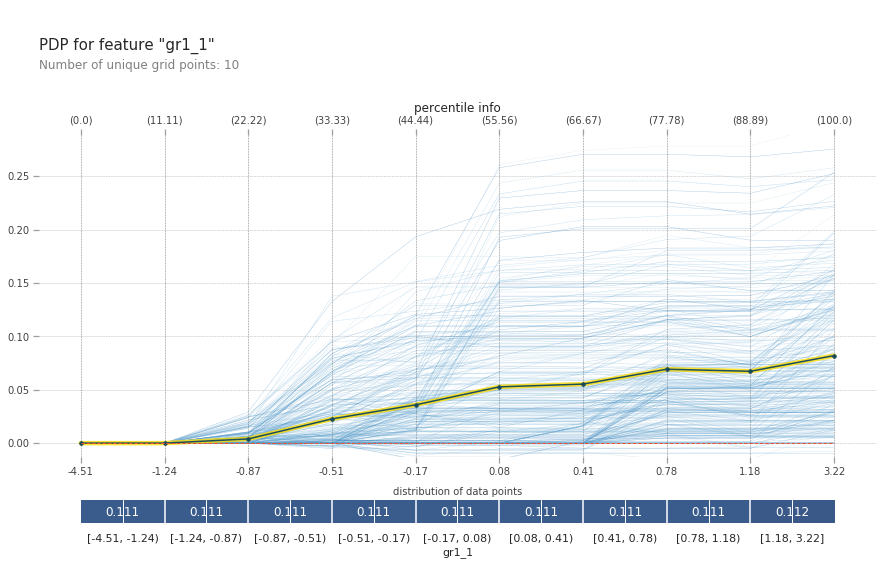

In [ ]:
with io.capture_output() as captured:
  pdp_Insulin = pdp.pdp_isolate(
    model=clf, dataset=X_train, model_features=X_train.columns, feature='gr1_1'
  )
  fig, axes = pdp.pdp_plot(
    pdp_Insulin, 'gr1_1', frac_to_plot=0.5, plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True
  ) 

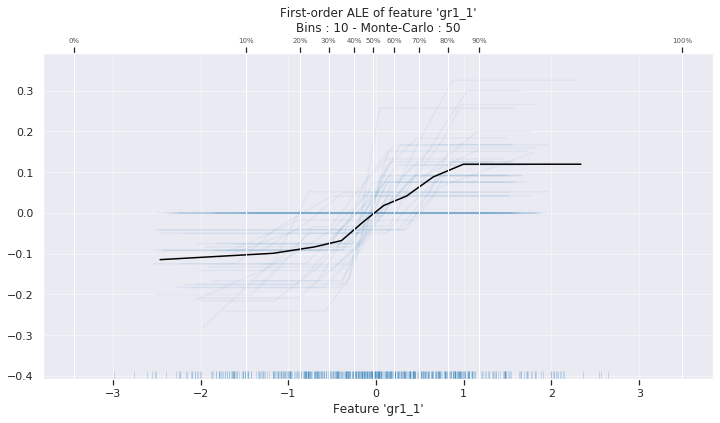

In [ ]:
#fig, ax = plt.subplots(figsize=(12, 6))
ale_plot(clf, X_train, 'gr1_1', monte_carlo=True)
plt.show()

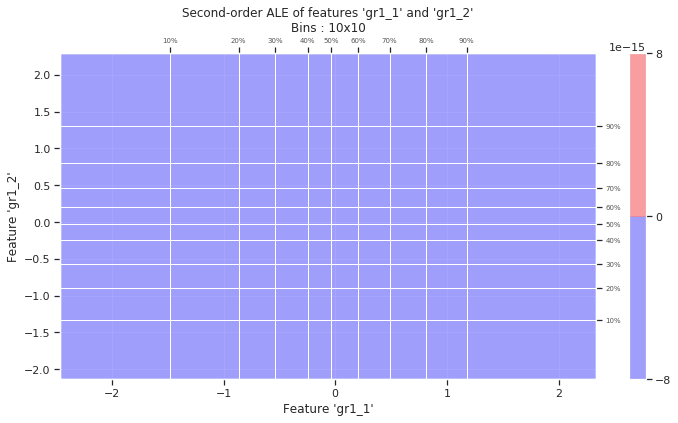

In [ ]:
  ale_plot(clf, X_train, ['gr1_1', 'gr1_2'], monte_carlo=True)
plt.show()

In [ ]:
start = timer()
f_ints = all_feature_interaction(clf, X_train, n_samples=1000)
end = timer()

time_last = int(end - start)
print(sec_to_date_string(time_last))

4h 6min 44sec


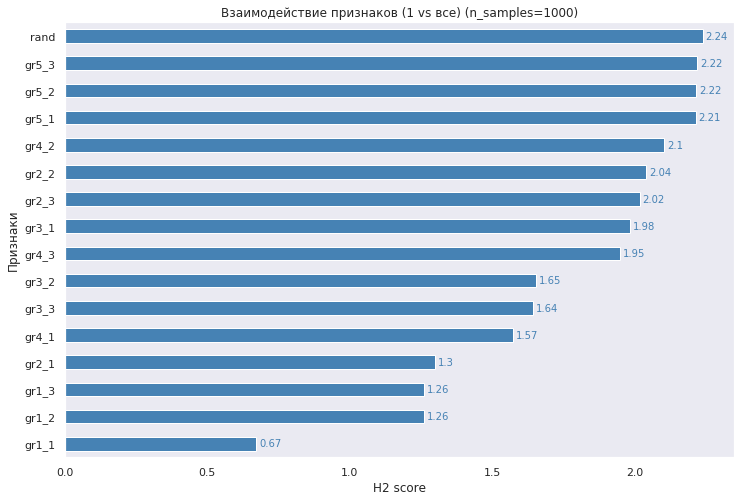

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

data = {'columns': X_train.columns, 
              'feature_interaction': f_ints}
data = pd.DataFrame(data,  index=data['columns'])
data.sort_values(by = "feature_interaction").plot(kind = "barh", color = "steelblue", legend = False, grid = True, ax = ax) 
plt.grid(False)
ax.set_title('Взаимодействие признаков (1 vs все) (n_samples=1000)')
ax.set_ylabel('Признаки')
ax.set_xlabel('H2 score')

for i, v in enumerate(sorted(data.feature_interaction)):
    plt.text(v+0.01, i, str(round(v, 2)), color='steelblue', va="center")

$H_{j}^{2}=\sum_{i=1}^{n}\left[\hat{f}\left(x^{(i)}\right)-P D_{j}\left(x_{j}^{(i)}\right)-P D_{-j}\left(x_{-j}^{(i)}\right)\right]^{2} / \sum_{i=1}^{n} \hat{f}^{2}\left(x^{(i)}\right)$

# Working with libraries

#### Let's save all the importances things in the one table

In [ ]:
begin = timer()
all_fi = get_feature_importances(clf, X_train, y_train, X_valid, y_valid, f1_metric)
all_fi.reset_index(inplace=True)
all_fi.to_csv(path_to_datasets + 'all_fi.csv', sep='\t', encoding='utf-8', index=False)
all_fi.set_index('index', inplace=True)
end = timer()
print(sec_to_date_string(int(end - begin)))

norm_all_fi = (all_fi.abs() / all_fi.abs().sum(axis=0)).fillna(0)
norm_all_fi.reset_index(inplace=True)
norm_all_fi.to_csv(path_to_datasets + 'norm_all_fi.csv', sep='\t', encoding='utf-8', index=False)
norm_all_fi.set_index('index', inplace=True)
norm_all_fi.sort_values('shap (Tree)', ascending=False)

1h 42min 22sec


,rfpimp (permutation),eli5 (gain),pyBreakDown (up),shap (Tree),lime,"exp_m (p, lgbm)","exp_m (p, mlp)",permutation (nll)
index,,,,,,,,
gr4_1,0.240604,0.169954,0.085250,0.263916,0.011551,0.069323,0.078161,0.102159
gr2_1,0.152191,0.137484,0.019569,0.207340,0.207116,0.105959,0.054421,0.081687
gr5_1,0.239728,0.195044,0.262205,0.159873,0.000000,0.047013,0.153928,0.101490
gr3_1,0.131148,0.180216,0.249407,0.151890,0.037101,0.122043,0.086363,0.072497
gr1_2,0.005782,0.015446,0.005806,0.071762,0.134075,0.010987,0.018556,0.048537
gr1_1,0.177058,0.193936,0.257049,0.043623,0.391365,0.029459,0.058780,0.095671
gr4_3,0.000182,0.010290,0.010700,0.033353,0.000000,0.036374,0.053658,0.050034
gr5_3,0.001324,0.011005,0.010067,0.020868,0.000000,0.101830,0.144386,0.049488
gr5_2,0.014172,0.015110,0.047156,0.012895,0.000000,0.166556,0.084457,0.052510


In [ ]:
# norm_all_fi = pd.read_csv(path_to_datasets + 'norm_all_fi.csv', sep='\t', encoding='utf-8')
# norm_all_fi.set_index('index', inplace=True)

# all_fi = pd.read_csv(path_to_datasets + 'all_fi.csv', sep='\t', encoding='utf-8')
# all_fi.set_index('index', inplace=True)

In [ ]:
pd_ind = 0
flatten_im = pd.DataFrame(columns=['feature', 'im_type', 'score'])
for i in range(len(norm_all_fi)):
    for j in range(len(norm_all_fi.iloc[0])):
        flatten_im.loc[pd_ind] = [norm_all_fi.index[i],
                                  norm_all_fi.columns[j],
                                  norm_all_fi.iloc[i, j]]
        pd_ind += 1

first_features = flatten_im[flatten_im['feature'].str.contains('_1', regex=False)]

In [ ]:
first_features.sample(5)

,feature,im_type,score
51,gr3_1,shap (Tree),0.151890
103,gr5_1,permutation (nll),0.101490
102,gr5_1,"exp_m (p, mlp)",0.153928
0,gr1_1,rfpimp (permutation),0.177058
24,gr2_1,rfpimp (permutation),0.152191


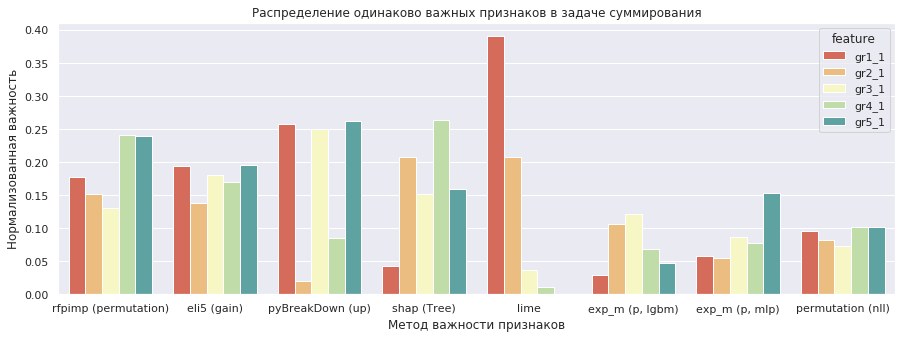

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(x="im_type", y="score", hue="feature", data=first_features, palette='Spectral')
ax.set_title('Распределение одинаково важных признаков в задаче суммирования')
ax.set_ylabel('Нормализованная важность')
ax.set_xlabel('Метод важности признаков')
fig.savefig(path_to_datasets + "TargetSum_impFeatures.pdf", bbox_inches='tight')
plt.show()

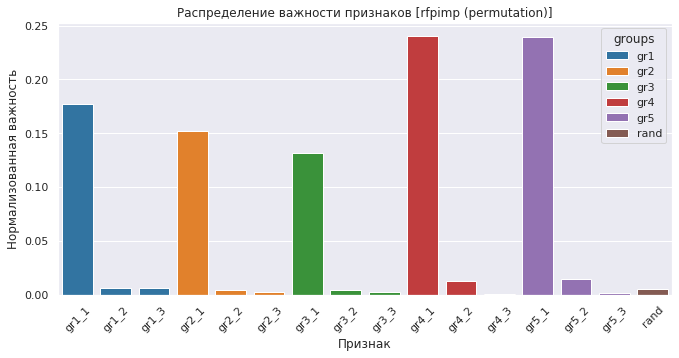

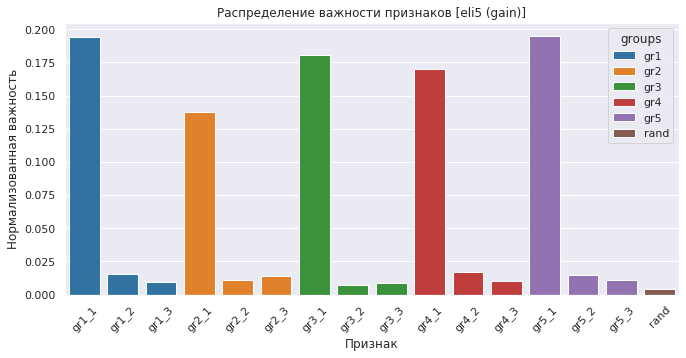

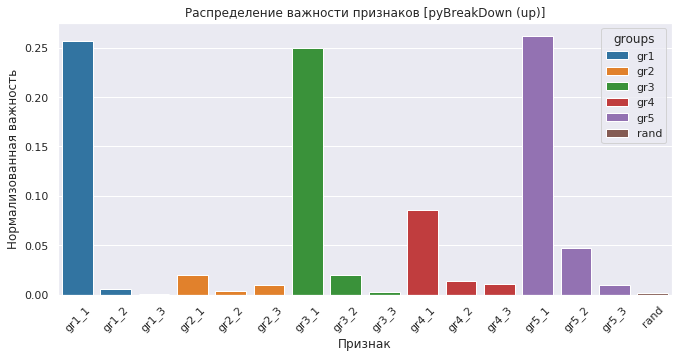

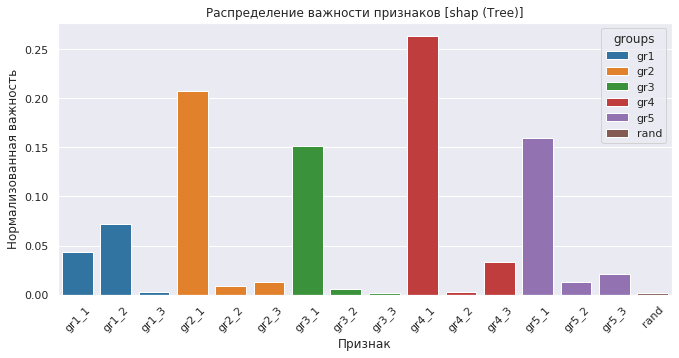

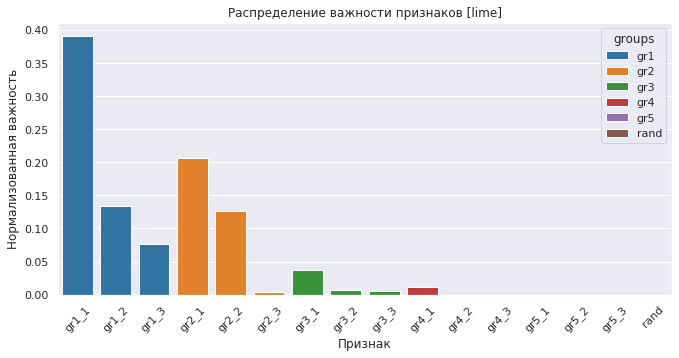

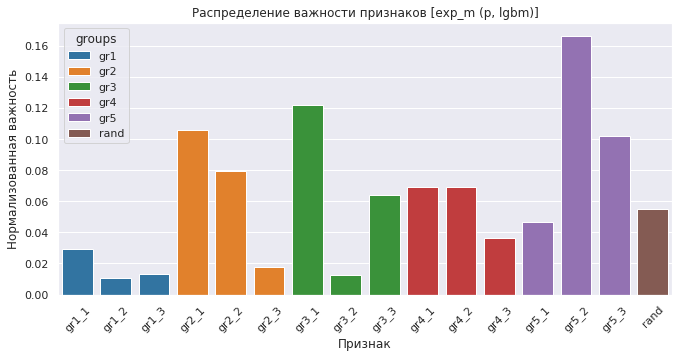

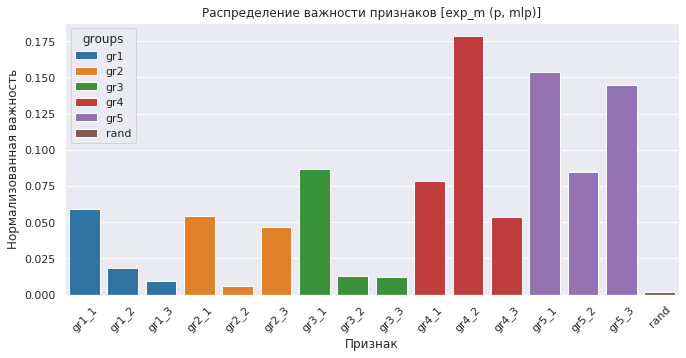

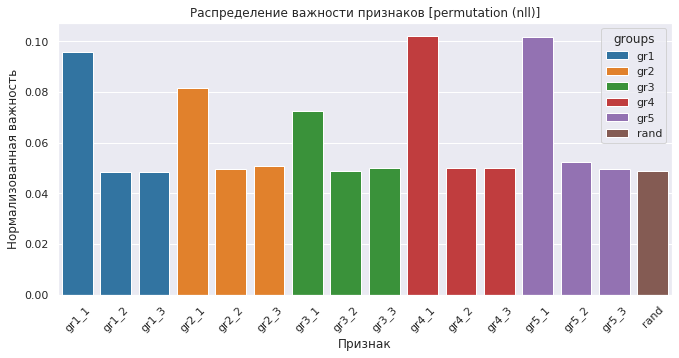

In [ ]:
im_methods = [rfpimp_dt_im, eli5_dt_im, pyBreakDown_dt_im, shap_dt_im, lime_dt_im,
              my_cxplain_lgbm, my_cxplain_mlp, wrap_nll_permutation_im]
im_names_methods = ['rfpimp (permutation)', 'eli5 (gain)', 'pyBreakDown (up)', 'shap (Tree)', 'lime',
                    'exp_m (p, lgbm)', 'exp_m (p, mlp)', 'permutation (nll)']

for name in im_names_methods:
    fig, ax = plt.subplots(figsize=(11, 5))
    ax = sns.barplot(x="feature", y="score", data=flatten_im[flatten_im['im_type'] == name], 
                    hue=[i[:-2] for i in all_fi.index[:-1]] + [all_fi.index[-1]], dodge=False)
    ax.set_title('Распределение важности признаков [' + name + ']')
    ax.set_ylabel('Нормализованная важность')
    ax.set_xlabel('Признак')
    plt.legend(title='groups')
    plt.xticks(rotation=45)
    fig.savefig(path_to_datasets + 'TargetSum_allFeatures_' + name + '.pdf', bbox_inches='tight')
    plt.show()

**rfpimp (permutation)**: bigger correlation makes several feature important  
**lime**: bigger correlation makes all features gradually unimportant

# Experiments

## Setup 1: Sampled feature importance
1. Calculate overall feature importance
2. Sample n percent features according to fi scores
3. Retrain base model, check metric

Тут shap (nsamples=200)

In [ ]:
params = {
    'num_iter': 1000,
    'sample_size': [0.3, 0.5, 0.7]
}

begin = timer()
results = mean_sampled_score(clf, norm_all_fi, X_train, y_train, X_test, y_test, 
                             num_iter=params['num_iter'], sample_size=params['sample_size'], metric=f1_score)
end = timer()
print(sec_to_date_string(int(end - begin)))

1h 34min 45sec


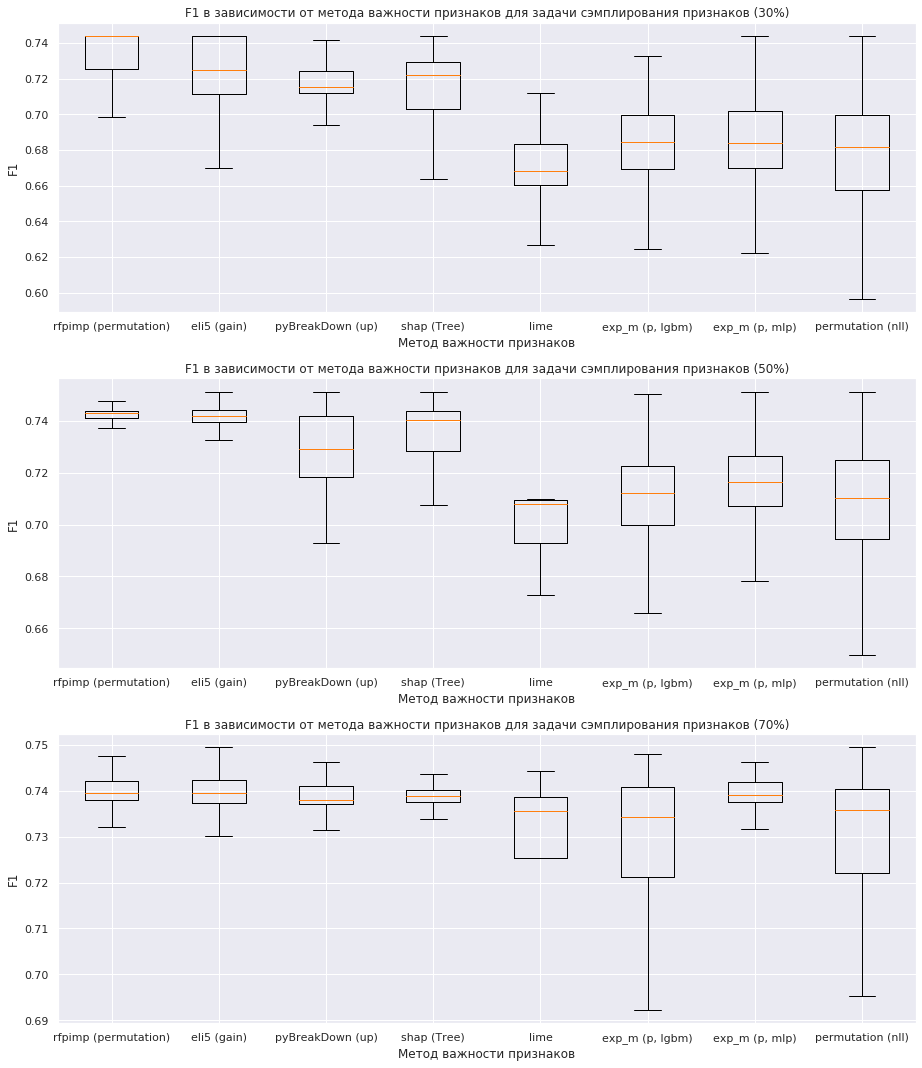

In [ ]:
plot_setup_1(results, params)
plt.show()

## Setup 2: RFE

Тут shap (nsamples=200)

In [ ]:
begin = timer()
with io.capture_output() as captured:
    results = setup_2(clf, im_methods, im_names_methods, f1_metric, X_train, y_train, X_valid, y_valid,
                      X_test, y_test, final_size=0.3, n_iter=1)
end = timer()
print(sec_to_date_string(int(end - begin)))

11h 40min 10sec


In [ ]:
with open(path_to_datasets + 'results_setup2.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

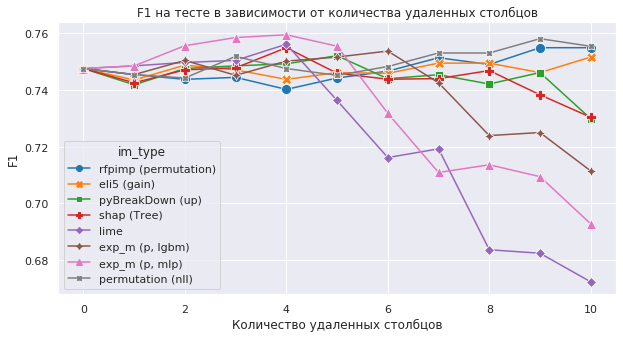

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(
    data=results,
    x="n_removed", y="score", hue="im_type", style="im_type",
    markers=True, dashes=False, ax=ax, markersize=10
)

ax.set_title('F1 на тесте в зависимости от количества удаленных столбцов')
ax.set_ylabel('F1')
ax.set_xlabel('Количество удаленных столбцов')

fig.savefig(path_to_datasets + 'RFE_f1.pdf', bbox_inches='tight')
plt.show()

## Setup 3: Feature importance of copy
1. Take the most important variable on whole train dataset
2. Add copy of it to data
3. Remove the least important variable, besides variables at 1. and 2.
4. Check importances (sums to 1) of the remanings variables
5. Remember fi of variables at 1. and 2.


Тут shap (nsamples=100)

In [15]:
begin = timer()
with io.capture_output() as captured:
    m_names, results = setup_3(clf, im_methods, f1_metric, X_train, y_train, X_valid, y_valid,
                            X_test, y_test, final_size=0.3)
end = timer()
print(sec_to_date_string(int(end - begin)))

23h 36min 12sec


In [16]:
with open(path_to_datasets + 'results_setup3_1.pickle', 'wb') as handle:
    pickle.dump((m_names, results), handle, protocol=pickle.HIGHEST_PROTOCOL)

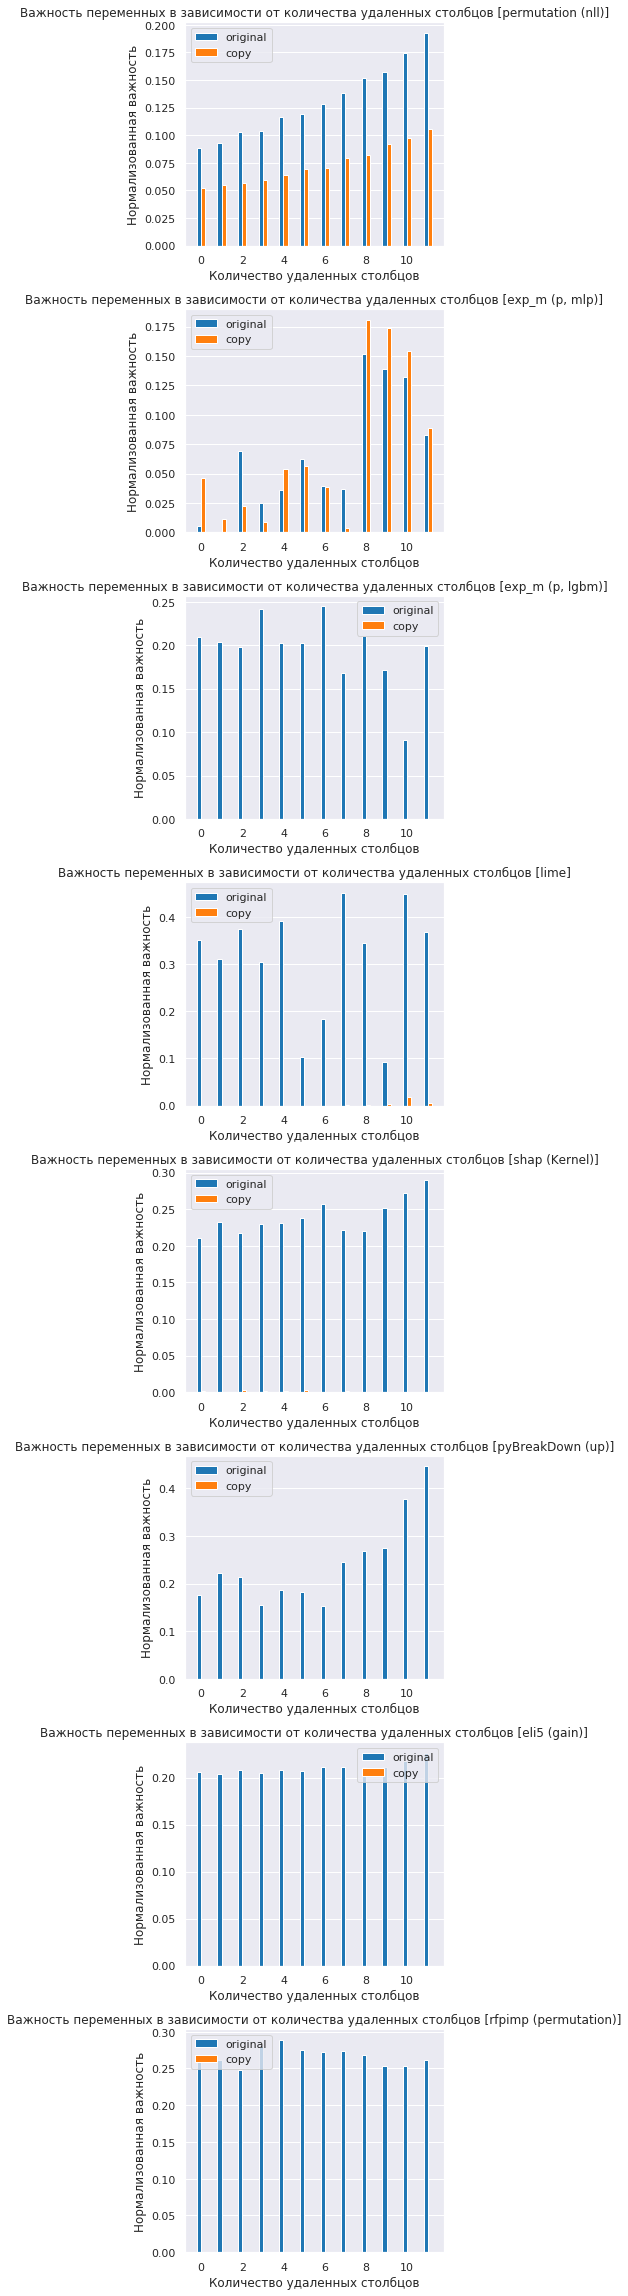

In [17]:
plot_setup_3(results, m_names, 'lgbm')
plt.show()

In [9]:
# Features that are important on the training set but not on the held-out set might cause the model to overfit.
X_, X_test, y_, y_test = train_test_split(data.drop(columns=['target']), data['target'], test_size=0.2,random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2,random_state=random_state)

In [10]:
scaler = skl.preprocessing.StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train.iloc[:, :])
X_valid.iloc[:, :] = scaler.transform(X_valid.iloc[:, :])
X_test.iloc[:, :] = scaler.transform(X_test.iloc[:, :])

In [11]:
clf = skl.svm.SVC(kernel='linear', probability=True, random_state=random_state)
clf.fit(X_train, y_train)
print("F1-score на тесте ", f1_score(y_test, clf.predict(X_test)))

F1-score на тесте  0.7547169811320755


In [14]:
begin = timer()
with io.capture_output() as captured:
    m_names, results = setup_3(clf, im_methods, f1_metric, X_train, y_train, X_valid, y_valid,
                            X_test, y_test, final_size=0.3)
end = timer()
print(sec_to_date_string(int(end - begin)))

10h 54min 49sec


In [15]:
with open(path_to_datasets + 'results_setup3_2.pickle', 'wb') as handle:
    pickle.dump((m_names, results), handle, protocol=pickle.HIGHEST_PROTOCOL)

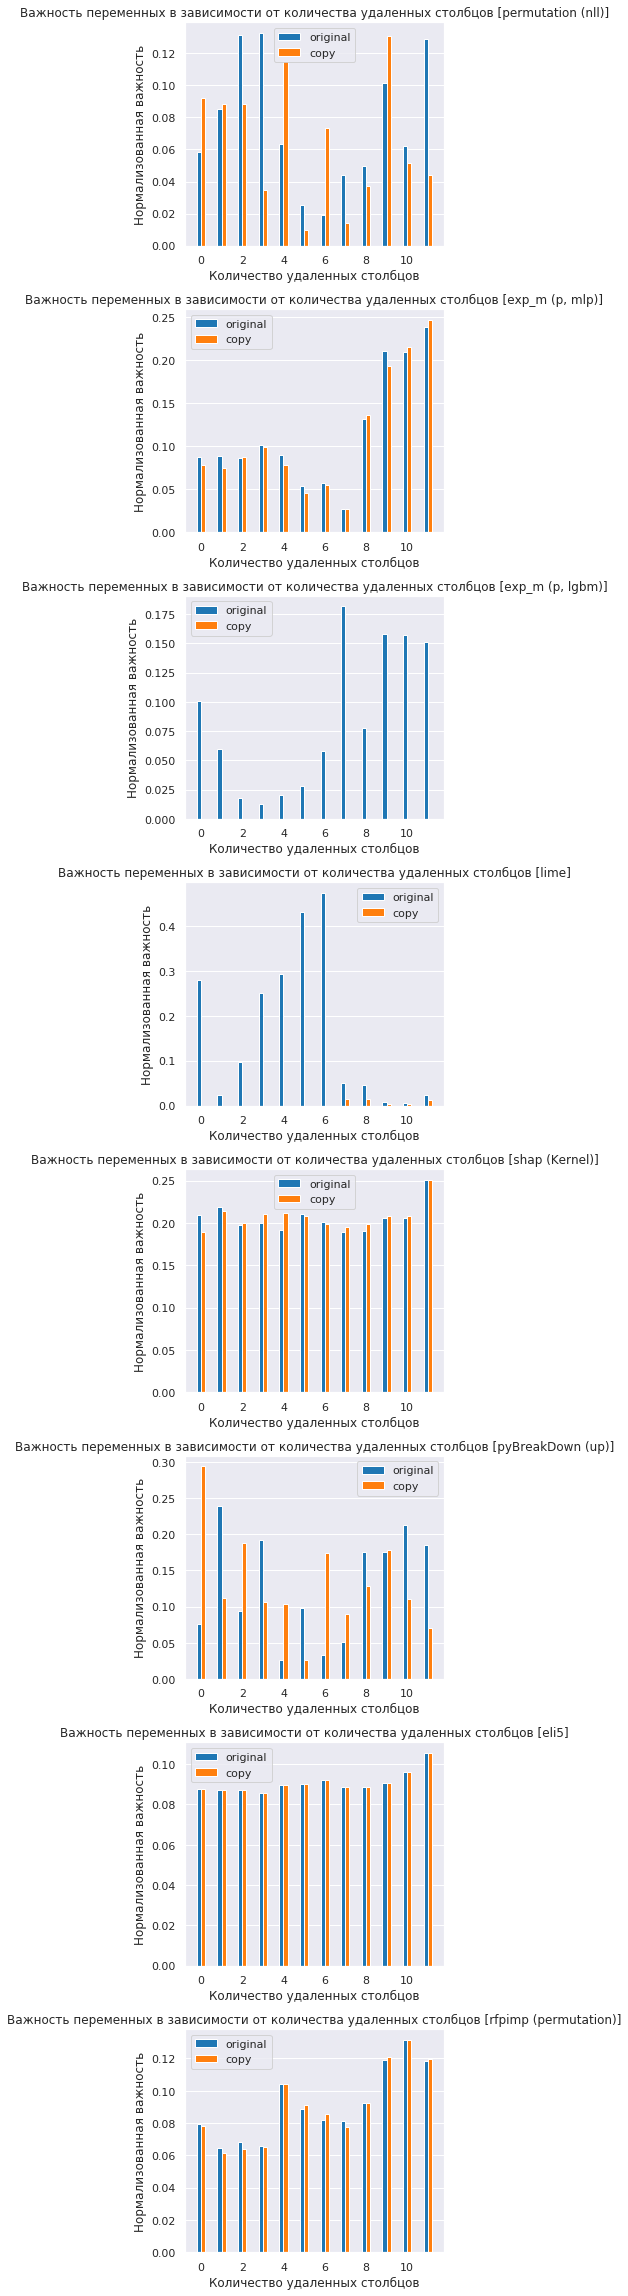

In [16]:
plot_setup_3(results, m_names, 'svm')
plt.show()